<a href="https://www.kaggle.com/code/rahuljaisy/scientific-eda-structure-property-visualization?scriptVersionId=246583094" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SCIENTIFIC OBJECTIVES:

# 1. Uncover physicochemical relationships between polymer structures and properties
# 2. Identify latent patterns beyond surface level statistics
# 3. Validate dataset integrity for materials science applications
# Dataset: NeurIPS Open Polymer Prediction 2025
# Source: https://www.kaggle.com/competitions/neurips-open-polymer-prediction-2025/data

In [1]:
# Section 0: Package Installation 
# Required for RDKit functionality in Kaggle
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 64.7 MB/s eta 0:00:00


In [2]:
# Section 1: Environment Setup 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Computational reproducibility
SEED = 42
np.random.seed(SEED)
tqdm.pandas()

In [3]:
# Section 2: Data Loading and Validation 
try:
    train = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
    test = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')
    print(f"Data loaded successfully | Train: {train.shape} | Test: {test.shape}")
    
    # Molecular validation
    assert train.SMILES.apply(lambda x: Chem.MolFromSmiles(x) is not None).all(), "Invalid SMILES detected"
except Exception as e:
    print(f"Data loading failed: {str(e)}")
    raise

# Memory optimization
float_cols = train.select_dtypes('float64').columns
train[float_cols] = train[float_cols].astype('float32')

# Test set doesn't have target columns
test_float_cols = test.select_dtypes('float64').columns
if len(test_float_cols) > 0:
    test[test_float_cols] = test[test_float_cols].astype('float32')

Data loaded successfully | Train: (7973, 7) | Test: (3, 2)


In [4]:
# Section 3: Data Authenticity Verification
print("\nDATA AUTHENTICITY METRICS:")
print("Thermodynamic Consistency Check:")
thermo_violations = train[(train['Density'] <= 0) | (train['Tg'] < 0) | (train['Tc'] < 0)]
print(f"Physical law violations: {len(thermo_violations)}")

print("\nPolymer Chain Length Analysis:")
train['polymer_length'] = train.SMILES.str.len()
test['polymer_length'] = test.SMILES.str.len()
print(f"Mean chain length calculated")

print("\nStereochemical Complexity:")
train['chiral_centers'] = train.SMILES.progress_apply(
    lambda s: len(Chem.FindMolChiralCenters(Chem.MolFromSmiles(s), includeUnassigned=True)) 
    if Chem.MolFromSmiles(s) is not None else 0)
print(f"Chiral centers identified")


DATA AUTHENTICITY METRICS:
Thermodynamic Consistency Check:
Physical law violations: 89

Polymer Chain Length Analysis:
Mean chain length calculated

Stereochemical Complexity:


100%|██████████| 7973/7973 [00:04<00:00, 1618.85it/s]

Chiral centers identified


In [5]:
# Section 4: Molecular Descriptor Computation 
def compute_molecular_descriptors(smiles):
    """Compute RDKit descriptors with error handling"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return {
            'mol_weight': Descriptors.MolWt(mol),
            'ring_count': Descriptors.RingCount(mol),
            'logp': Descriptors.MolLogP(mol),
            'h_bond_donors': Descriptors.NumHDonors(mol),
            'rotatable_bonds': Descriptors.NumRotatableBonds(mol)
        }
    except:
        return None

print("\nComputing Molecular Descriptors...")
train_descriptors = pd.DataFrame(train.SMILES.progress_apply(compute_molecular_descriptors).tolist())
train = pd.concat([train, train_descriptors], axis=1)

# Fill potential missing descriptor values
descriptor_cols = ['mol_weight', 'ring_count', 'logp', 'h_bond_donors', 'rotatable_bonds']
for col in descriptor_cols:
    if col in train.columns:
        train[col].fillna(train[col].median(), inplace=True)


Computing Molecular Descriptors...


100%|██████████| 7973/7973 [00:06<00:00, 1186.98it/s]


In [6]:
# Section 5: Advanced Data Quality Assessment
def comprehensive_quality_check(df, name):
    print(f"\n{name} DATASET INTEGRITY REPORT:")
    
    # Structural validation
    n_missing = df.isnull().sum().sum()
    n_duplicates = df.duplicated(subset=['SMILES']).sum()
    
    # Check for non-finite values only in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_invalid = df[numeric_cols].applymap(lambda x: not np.isfinite(x)).sum().sum()
    
    print(f"Missing Values: {n_missing}")
    print(f"Duplicate Polymers: {n_duplicates}")
    print(f"Non-finite Values: {n_invalid}")
    
    # Distributional stability
    print("\nDistributional Shifts (vs theoretical polymer properties):")
    theoretical_ranges = {
        'Density': (0.8, 1.5),
        'Tg': (150, 500),
        'Rg': (5, 50),
        'FFV': (0.05, 0.35),
        'Tc': (0.1, 0.5)
    }
    
    for prop, (low, high) in theoretical_ranges.items():
        if prop in df.columns:
            violations = sum((df[prop] < low) | (df[prop] > high))
            print(f"{prop} violations detected: {violations}")

comprehensive_quality_check(train, "TRAINING")


TRAINING DATASET INTEGRITY REPORT:
Missing Values: 30360
Duplicate Polymers: 0
Non-finite Values: 30360

Distributional Shifts (vs theoretical polymer properties):
Density violations detected: 31
Tg violations detected: 369
Rg violations detected: 0
FFV violations detected: 5231
Tc violations detected: 17


In [7]:
# Section 6: Target Property Statistical Analysis 
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
available_targets = [t for t in targets if t in train.columns]

print("\nTARGET PROPERTY STATISTICS:")
if available_targets:
    stat_summary = train[available_targets].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
    stat_summary.loc['skewness'] = train[available_targets].skew()
    stat_summary.loc['kurtosis'] = train[available_targets].kurt()
    display(stat_summary)
else:
    print("No target columns available for analysis")


TARGET PROPERTY STATISTICS:


,Tg,FFV,Tc,Density,Rg
count,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,96.452316,0.367212,0.256334,0.985484,16.419786
std,111.228279,0.029609,0.089538,0.146189,4.608641
min,-148.029739,0.226992,0.046500,0.748691,9.728355
1%,-90.165070,0.306384,0.084360,0.772621,10.064431
5%,-49.041019,0.327622,0.131700,0.806181,10.870906
25%,13.674509,0.349549,0.186000,0.890243,12.540328
50%,74.040184,0.364264,0.236000,0.948193,15.052195
75%,161.147598,0.380790,0.330500,1.062096,20.411068
95%,311.948700,0.416925,0.403350,1.234910,24.349463


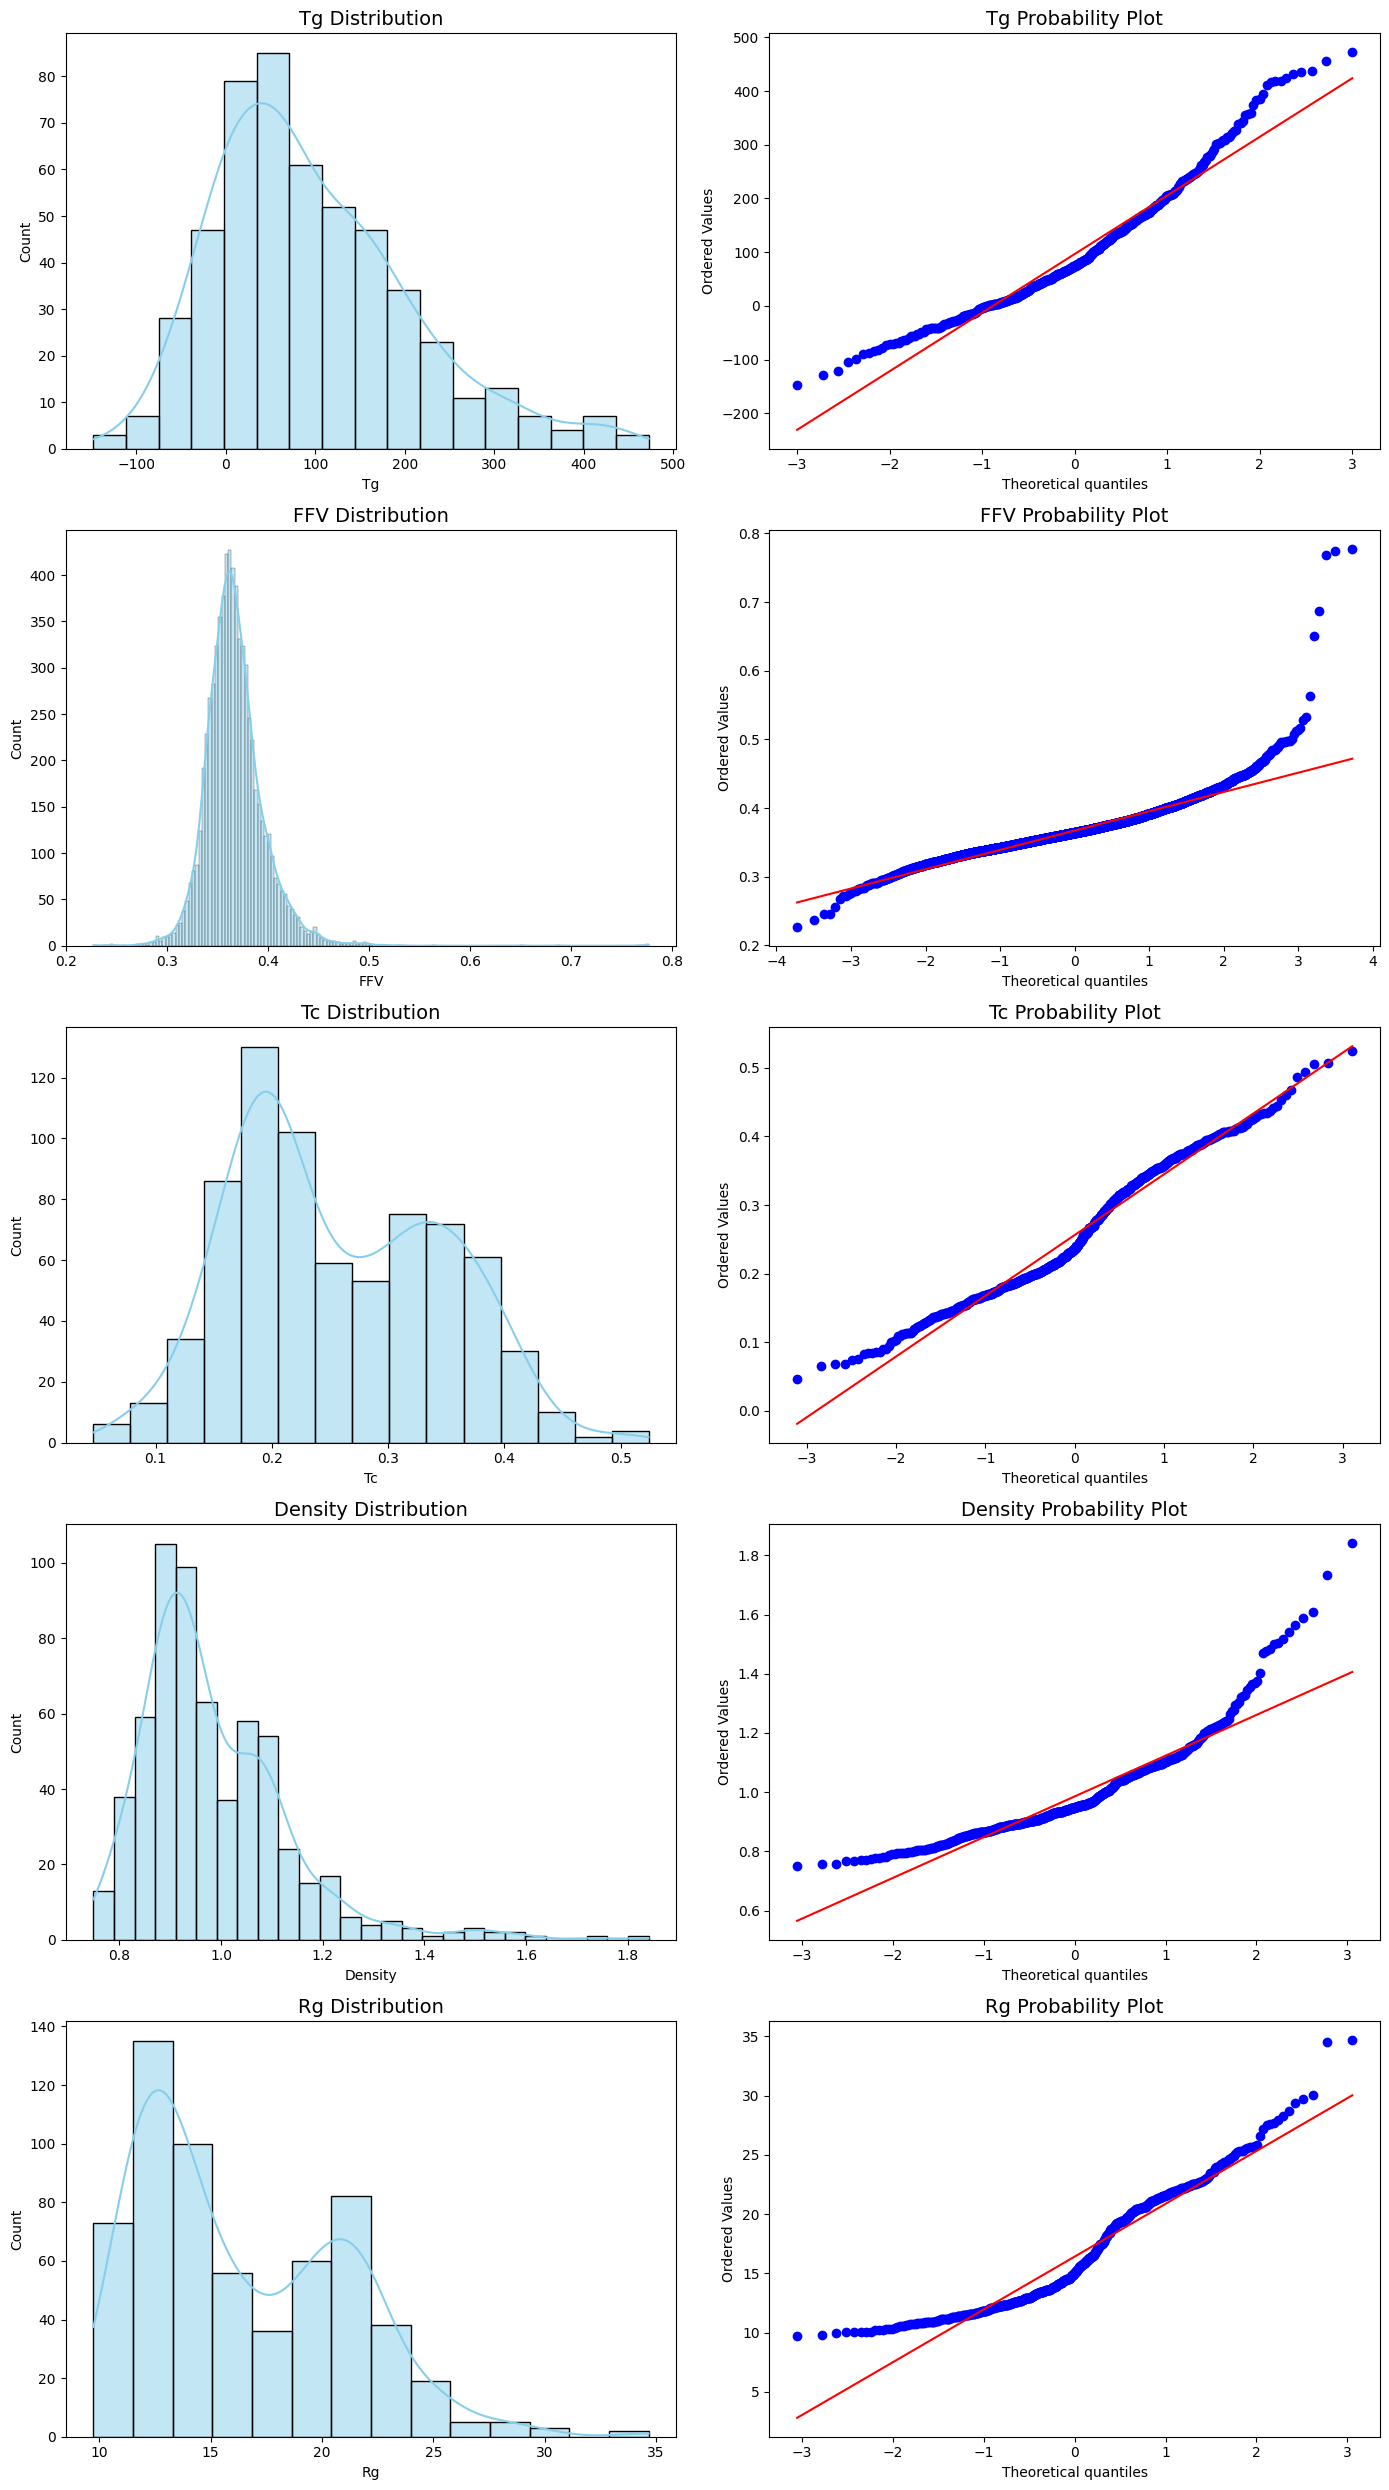

In [8]:
# Section 7: Distribution Visualization
available_targets = [t for t in targets if t in train.columns]
if available_targets:
    fig, axes = plt.subplots(len(available_targets), 2, figsize=(14, 5*len(available_targets)))
    
    for i, col in enumerate(available_targets):
        # Handle single target case
        if len(available_targets) == 1:
            ax_hist = axes[0]
            ax_qq = axes[1]
        else:
            ax_hist = axes[i, 0]
            ax_qq = axes[i, 1]
        
        sns.histplot(train[col], kde=True, ax=ax_hist, color='skyblue')
        ax_hist.set_title(f'{col} Distribution', fontsize=14)
        
        stats.probplot(train[col].dropna(), plot=ax_qq)
        ax_qq.set_title(f'{col} Probability Plot', fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No target columns available for visualization")


THERMODYNAMIC CROSS-PROPERTY ANALYSIS


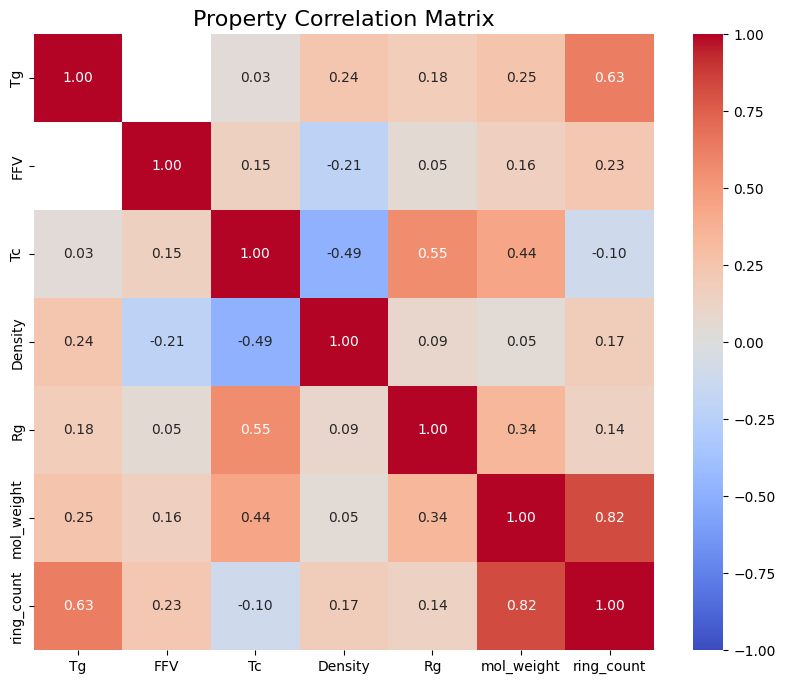

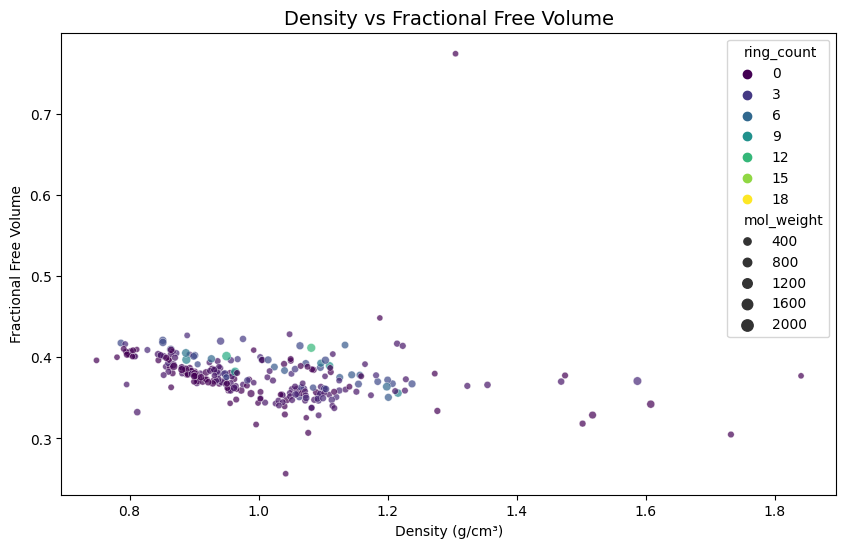

In [9]:
# Section 8: Thermodynamic Relationship Analysis 
print("\nTHERMODYNAMIC CROSS-PROPERTY ANALYSIS")

# Ensure we have the necessary columns
analysis_cols = [t for t in targets if t in train.columns] + ['mol_weight', 'ring_count']
analysis_cols = [col for col in analysis_cols if col in train.columns]

if len(analysis_cols) > 1:
    plt.figure(figsize=(10, 8))
    corr_matrix = train[analysis_cols].corr()
    sns.heatmap(
        corr_matrix,
        annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1
    )
    plt.title("Property Correlation Matrix", fontsize=16)
    plt.show()
    
    if 'Density' in train.columns and 'FFV' in train.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x='Density', y='FFV', 
            size='mol_weight' if 'mol_weight' in train.columns else None,
            hue='ring_count' if 'ring_count' in train.columns else None,
            data=train, palette='viridis', alpha=0.7
        )
        plt.title("Density vs Fractional Free Volume", fontsize=14)
        plt.xlabel("Density (g/cm³)")
        plt.ylabel("Fractional Free Volume")
        plt.show()
else:
    print("Insufficient columns for thermodynamic analysis")

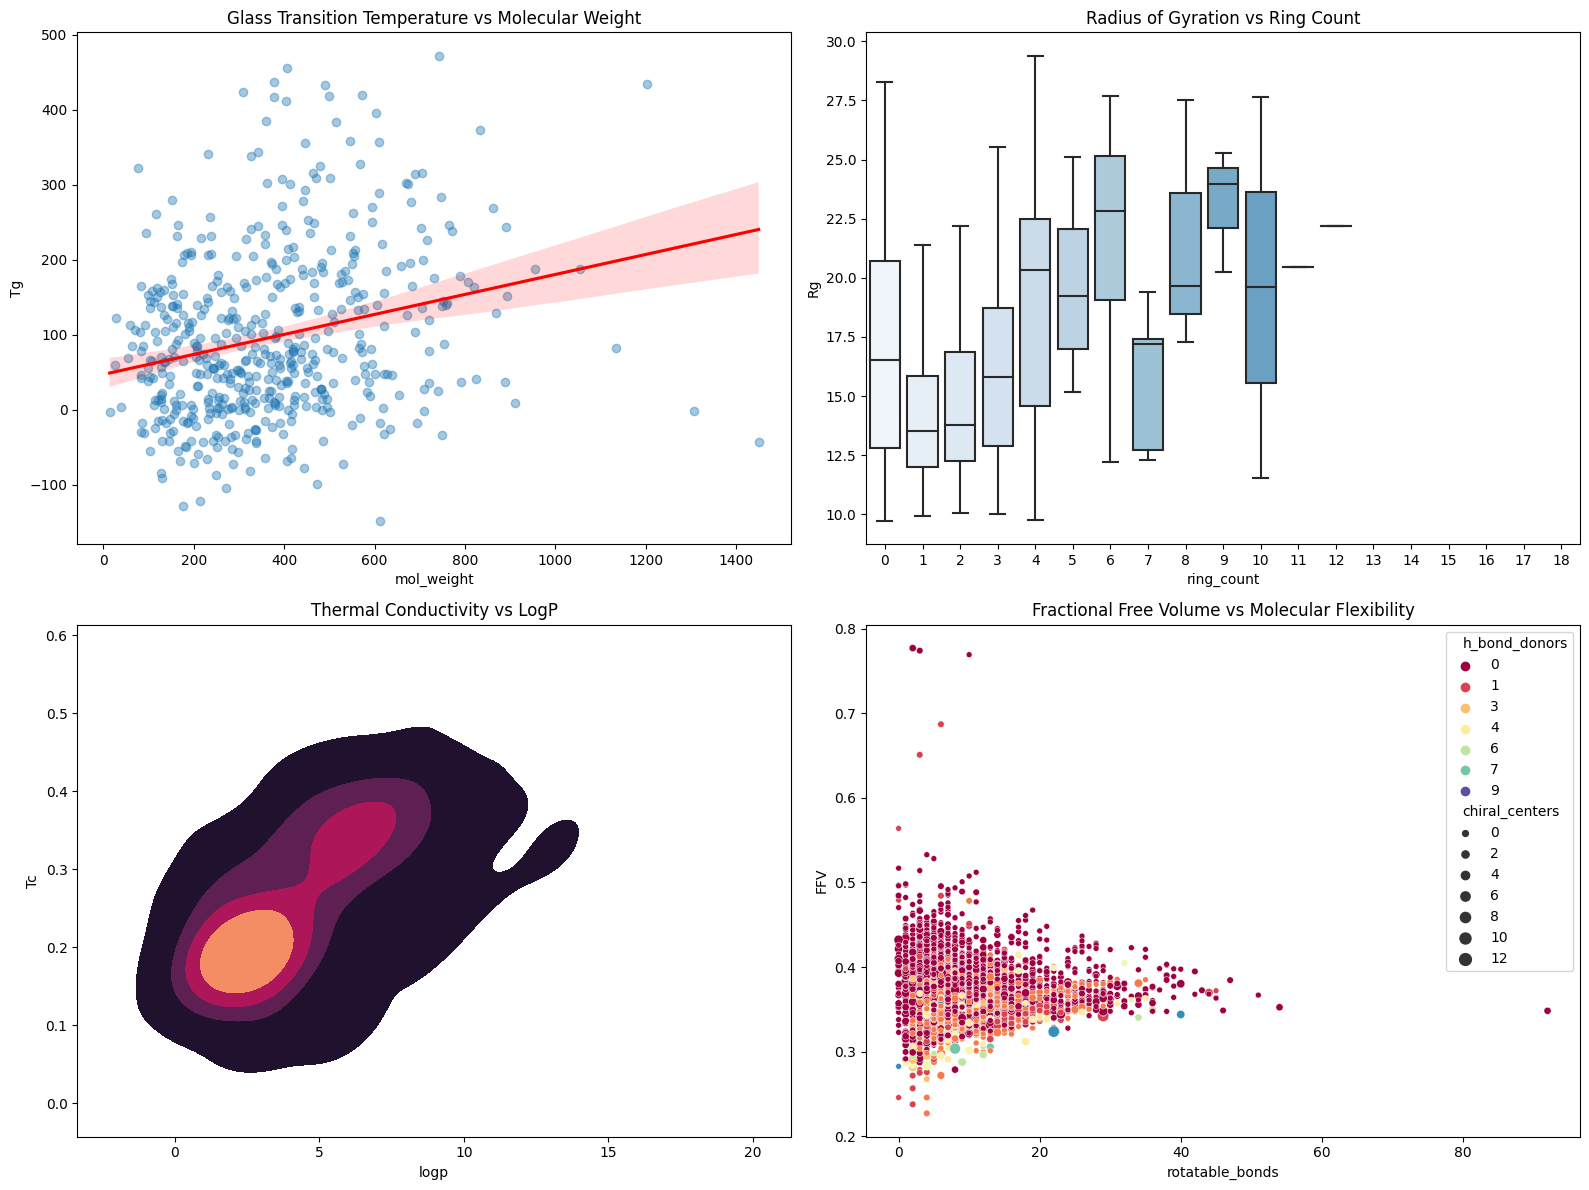

In [10]:
# Section 9: Polymer Structure Property Relationships 
# Create a safe list of columns to check
structure_property_cols = ['mol_weight', 'Tg', 'ring_count', 'Rg', 'logp', 'Tc', 'rotatable_bonds', 'FFV']
available_cols = [col for col in structure_property_cols if col in train.columns]

if set(available_cols).issuperset({'mol_weight', 'Tg', 'ring_count', 'Rg', 'rotatable_bonds', 'FFV'}):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Glass Transition Temperature vs Molecular Weight
    if 'mol_weight' in train.columns and 'Tg' in train.columns:
        sns.regplot(
            x='mol_weight', y='Tg', data=train, 
            ax=axes[0,0], scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
        )
        axes[0,0].set_title("Glass Transition Temperature vs Molecular Weight")

    # Plot 2: Radius of Gyration vs Ring Count
    if 'ring_count' in train.columns and 'Rg' in train.columns:
        sns.boxplot(
            x='ring_count', y='Rg', data=train,
            ax=axes[0,1], showfliers=False, palette='Blues'
        )
        axes[0,1].set_title("Radius of Gyration vs Ring Count")

    # Plot 3: Thermal Conductivity vs LogP
    if 'logp' in train.columns and 'Tc' in train.columns:
        sns.kdeplot(
            x='logp', y='Tc', data=train,
            ax=axes[1,0], fill=True, cmap='rocket', levels=5
        )
        axes[1,0].set_title("Thermal Conductivity vs LogP")

    # Plot 4: Fractional Free Volume vs Molecular Flexibility
    if 'rotatable_bonds' in train.columns and 'FFV' in train.columns:
        sns.scatterplot(
            x='rotatable_bonds', y='FFV', 
            size='chiral_centers' if 'chiral_centers' in train.columns else None,
            hue='h_bond_donors' if 'h_bond_donors' in train.columns else None,
            data=train, ax=axes[1,1], palette='Spectral'
        )
        axes[1,1].set_title("Fractional Free Volume vs Molecular Flexibility")
    
    plt.tight_layout()
    plt.show()
else:
    print("Missing required columns for structure property visualization")

In [11]:
# Section 10: Anomaly Detection
print("\nSTRUCTURAL OUTLIER ANALYSIS")

from sklearn.ensemble import IsolationForest

# Prepare columns for outlier detection
outlier_cols = [t for t in targets if t in train.columns] 
if 'mol_weight' in train.columns:
    outlier_cols.append('mol_weight')
if 'logp' in train.columns:
    outlier_cols.append('logp')

if outlier_cols:
    # Create a clean dataset without missing values
    clean_df = train[outlier_cols].dropna()
    
    # Only proceed if we have at least 2 samples
    if len(clean_df) > 1:
        clf = IsolationForest(contamination=0.01, random_state=SEED)
        outliers = clf.fit_predict(clean_df)
        train.loc[clean_df.index, 'outlier_flag'] = outliers == -1
        outlier_count = train['outlier_flag'].sum()
        print(f"Detected structural outliers: {outlier_count}")

        if 'Density' in train.columns and 'FFV' in train.columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(
                x='Density', y='FFV', 
                hue='outlier_flag' if 'outlier_flag' in train.columns else None,
                data=train, palette={True: 'red', False: 'blue'},
                s=80, alpha=0.7
            )
            plt.title("Density FFV Space with Outlier Detection", fontsize=14)
            plt.show()
    else:
        print(f"Insufficient samples for outlier detection: {len(clean_df)} samples available")
else:
    print("Insufficient columns for outlier detection")


STRUCTURAL OUTLIER ANALYSIS
Insufficient samples for outlier detection: 0 samples available



SMILES STRUCTURAL DECOMPOSITION


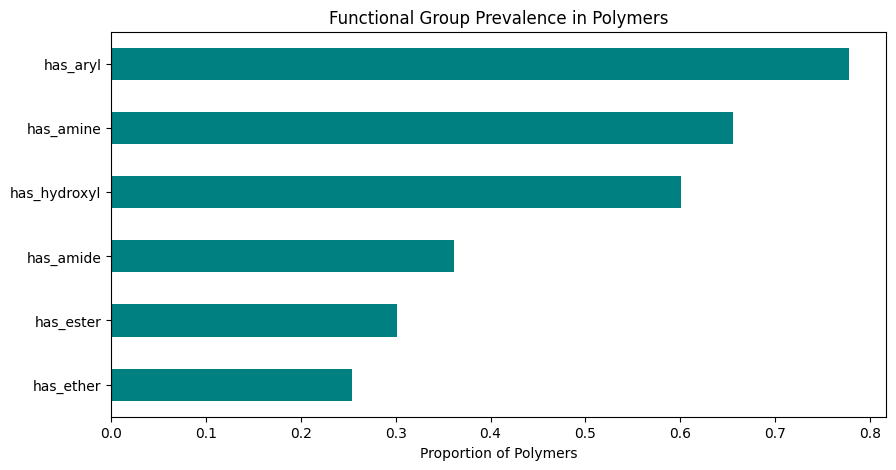

In [12]:
# Section 11: SMILES Structural Decomposition 
print("\nSMILES STRUCTURAL DECOMPOSITION")

functional_groups = {
    'ester': 'C(=O)O',
    'amide': 'C(=O)N',
    'ether': 'COC',
    'hydroxyl': 'O[#6]',
    'amine': '[#7]',
    'aryl': 'c1ccccc1'
}

for name, smarts in functional_groups.items():
    pattern = Chem.MolFromSmarts(smarts)
    if pattern:
        train[f'has_{name}'] = train.SMILES.apply(
            lambda s: 1 if (mol := Chem.MolFromSmiles(s)) and mol.HasSubstructMatch(pattern) else 0
        )

fg_cols = [f'has_{fg}' for fg in functional_groups if f'has_{fg}' in train.columns]
if fg_cols:
    fg_prevalence = train[fg_cols].mean().sort_values()
    plt.figure(figsize=(10, 5))
    fg_prevalence.plot(kind='barh', color='teal')
    plt.title("Functional Group Prevalence in Polymers")
    plt.xlabel("Proportion of Polymers")
    plt.show()
else:
    print("Functional group columns not created")


TRAIN-TEST DISTRIBUTION COMPARISON


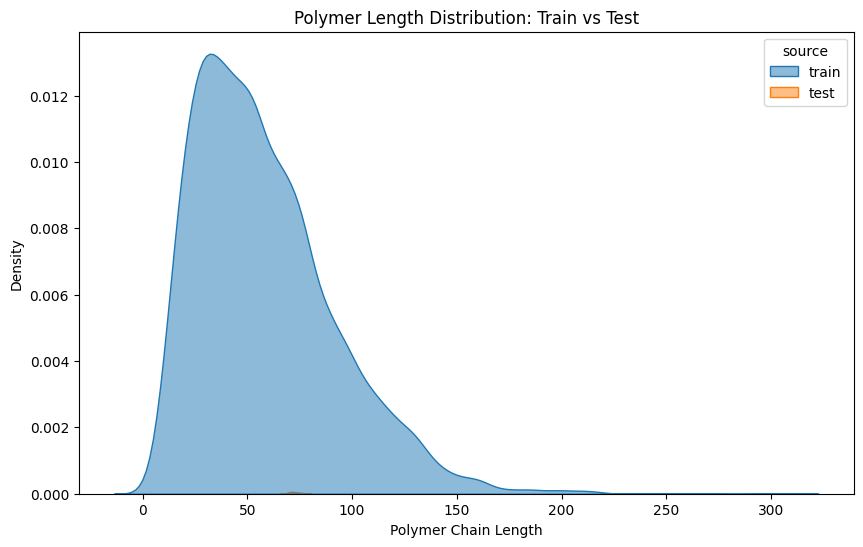

Kolmogorov-Smirnov p-value: 5.877e-02


In [13]:
# Section 12: Dataset Shift Analysis
print("\nTRAIN-TEST DISTRIBUTION COMPARISON")

if 'polymer_length' in train.columns and 'polymer_length' in test.columns:
    train['source'] = 'train'
    test['source'] = 'test'
    combined = pd.concat([train[['polymer_length', 'source']], 
                         test[['polymer_length', 'source']]])

    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=combined, x='polymer_length', hue='source', fill=True, alpha=0.5)
    plt.title("Polymer Length Distribution: Train vs Test")
    plt.xlabel("Polymer Chain Length")
    plt.show()

    # Only perform KS test if we have sufficient samples
    train_lengths = train.polymer_length.dropna()
    test_lengths = test.polymer_length.dropna()
    
    if len(train_lengths) > 0 and len(test_lengths) > 0:
        _, pval = stats.ks_2samp(train_lengths, test_lengths)
        print(f"Kolmogorov-Smirnov p-value: {pval:.3e}")
    else:
        print("Insufficient data for KS test")
else:
    print("Polymer length data not available for comparison")